# Categorizing Books - Based on Description
## Abhinav Vijayakumar (19BCE1311), Amar Dixit (19BCE1875).


### CSE4022 J-Component Final Project: Faculty - Dr. G. Bharadwaja Kumar (B2+TB2)

This NLP project(Book Categorizaion) uses Multi Label Classification, an instance/record can have multiple labels and the number of labels per instance is not fixed.

Books are not one-dimensional. One book can span several genres. This code aims at predicting a list of genres, given the summary as a feature for each book.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Necssary Imports:

In [ ]:
import pandas as pd
import numpy as np
import json
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xml.etree import ElementTree
import pickle
import random
from random import shuffle

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Getting the Dataset:

The dataset used is Blurb Genre Collection.
Ref: https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/blurb-genre-collection.html

The BlurbGenreCollection-EN is a dataset consisting of advertising descriptions of books - so called blurbs - for the English language. Each blurb is categorized into one or multiple categories. The categories are structured hierarchically.

An example entry of the resulting datset is shown below:

    <book date="2018-08-18" xml:lang="en">
      <title>2001: a Space Odyssey</title>
      <body>
        The classic science fiction novel that captures and expands on the vision of Stanley Kubrick´s
        immortal film-and changed the way we look at the stars and ourselves. From the savannas of Africa at the
        dawn of mankind to the rings of Saturn as man ventures to the outer rim of our solar system, 2001: A
        Space Odyssey is a journey unlike any other. This allegory about humanity´s exploration of the universe-and
        the universe`s reaction to humanity-is a hallmark achievement in storytelling that follows the crew of the
        spacecraft Discovery as they embark on a mission to Saturn. Their vessel is controlled by HAL 9000, an
        artificially intelligent supercomputer capable of the highest level of cognitive functioning that
        rivals-and perhaps threatens-the human mind. Grappling with space exploration, the perils of technology,
        and the limits of human power, 2001: A Space Odyssey continues to be an enduring classic of cinematic
        scope.
      </body>
      <copyright>(c) Penguin Random House</copyright>
      <metadata>
        <topics>
          <d0>Fiction</d0>
          <d1>Science Fiction</d1>
          <d1>Mystery & Suspense</d1>
          <d2>Suspense & Thriller</d2>
        </topics>
        <author>Arthur C. Clarke</author>
        <published>Sep 01, 2000 </published>
        <page_num> 320 Pages</page_num>
        <isbn>9780451457998</isbn>
        <url>https://www.penguinrandomhouse.com/books/325356/2001- a-space-odyssey-by-arthur-c-clarke/</url>
      </metadata>
    </book>

In [ ]:
def getDataFrame(filename):
    dataset=[]
    tree = ElementTree.parse(filename)
    root = tree.getroot()

    for book in root.findall('book'):
        for metadata in book.find('metadata'):
            x=metadata
            break
        a=[]
        if(x.find('d3')!=None):
            a.append(x.find('d3').text)
        if(x.find('d2')!=None):
            a.append(x.find('d2').text)
        if(x.find('d1')!=None):
            a.append(x.find('d1').text)
        if(x.find('d0')!=None):
            a.append(x.find('d0').text)

        if len(a) != 0:        
            dataset.append([book.find('title').text,a,book.find('body').text])
    return dataset  

dataset = getDataFrame('/content/drive/MyDrive/Colab Notebooks/Datasets/BlurbGenreCollection_EN_train.xml')
dataset2 = getDataFrame('/content/drive/MyDrive/Colab Notebooks/Datasets/BlurbGenreCollection_EN_test.xml')
dataset = dataset + dataset2

Creating DataFrame from list of data:

In [ ]:
df=pd.DataFrame(dataset,columns=['Name','Genres','Summary'])

In [ ]:
df

,Name,Genres,Summary
0,"The New York Times Daily Crossword Puzzles: Thursday, Volume 1","[Games, Nonfiction]","Monday’s Crosswords Do with EaseTuesday’s Crosswords Not a BreezeWednesday’s Crosswords Harder StillThursday’s Crosswords Take Real SkillFriday’s Crosswords — You’ve Come This Far…Saturday’s Crosswords — You’re a Star!For millions of people, the New York Times crossword puzzles are as essential ..."
1,Creatures of the Night (Second Edition),"[Graphic Novels and Manga, Fiction]","Two of literary comics modern masters present a pair of magical and disturbing stories of strange creatures who are not quite what they seem! In The Price, a mysterious feline engages in a nightly conflict with an unseen, vicious foe. The Daughter of Owls recounts an eerie tale of a beautiful or..."
2,Cornelia and the Audacious Escapades of the Somerset Sisters,"[Children’s Middle Grade Books, Children’s Books]","Eleven-year-old Cornelia is the daughter of two world-famous pianists—a legacy that should feel fabulous, but instead feels just plain lonely. She surrounds herself with dictionaries and other books to isolate herself from the outside world. But when a glamorous neighbor named Virginia Somerset ..."
3,The Alchemist's Daughter,"[Historical Fiction, Fiction]","During the English Age of Reason, a woman cloistered since birth learns that knowledge is no substitute for experience.Raised by her father in near isolation in the English countryside, Emilie Selden is trained as a brilliant natural philosopher and alchemist. In the spring of 1725, father and d..."
4,Dangerous Boy,"[Teen and Young Adult Mystery and Suspense, Teen and Young Adult]","A modern-day retelling of The Strange Case of Dr. Jekyll and Mr. Hyde with a chilling twist Harper has never been worried about falling in love, something she is skeptical even exists. But everything changes when Logan moves to town, and to Harper’s shock, the two tumble into an intense romance...."
...,...,...,...
77104,Cathedral of the Sea,"[Romance, Fiction]","An unforgettable fresco of a golden age in fourteenth-century Barcelona, Cathedral of the Sea is a thrilling historical novel of friendship and revenge, plague and hope, love and war. Arnau Estanyol arrives in Barcelona to find a city dominated by the construction of the city’s great pride—the..."
77105,Understanding the Messages of Your Body,"[Alternative Therapies, Health and Fitness, Nonfiction]","Fears, anxieties, traumas, and physical and emotional shocks imprint on the body and remain dormant in its vast memory store until they are roused by an event or encounter. They may manifest in a different form or place—a fearful incident may transform itself into a stomachache or a headache, or..."
77106,Knockout,"[Alternative Therapies, Health and Fitness, Nonfiction]","In Knockout, Suzanne Somers interviews doctors who are successfully using the most innovative cancer treatments—treatments that build up the body rather than tear it down. Somers herself has stared cancer in the face, and a decade later she has conquered her fear and has emerged confident with t..."
77107,The End of the Suburbs,"[Domestic Politics, Politics, Nonfiction]","“The government in the past created one American Dream at the expense of almost all others: the dream of a house, a lawn, a picket fence, two children, and a car. But there is no single American Dream anymore.”For nearly 70 years, the suburbs were as American as apple pie. As the middle class ba..."


In [ ]:
genre_count = {}
def draw_genre_plot(df):
    global genre_count
    genre_count = {}
    for index,row in df.iterrows():
        genres = row["Genres"]
        for g in genres:
            try:
                genre_count[g] += 1
            except:
                genre_count[g] = 1
                
    print("Total unique genres:", len(genre_count.keys()))
    genre_count_dist = nltk.FreqDist(genre_count) 
    genre_count_df = pd.DataFrame({'Genre': list(genre_count_dist.keys()), 
                                  'Count': list(genre_count_dist.values())})
    g = genre_count_df.nlargest(columns="Count", n = 50) 
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=g, x= "Count", y = "Genre") 
    ax.set(ylabel = 'Count') 
    plt.show()

Our current genre distribution is as shown:

Total unique genres: 139


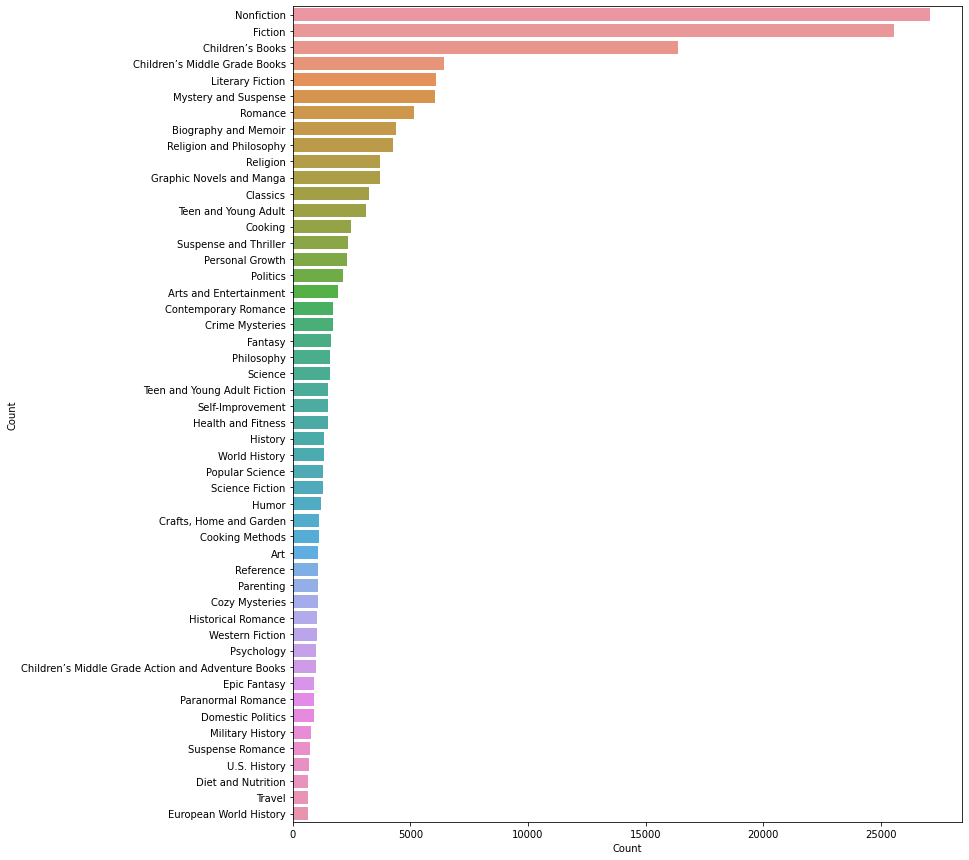

In [ ]:
draw_genre_plot(df)

For better data distribution, we did data augmentation.

Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data.

In [ ]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

Functions for Data Augmentation:

In [ ]:
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n: 
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return new_words

In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

In [ ]:
def applysynonym(row):
    words = nltk.word_tokenize(row)
    n = len(words)
    res = synonym_replacement(words,n//10)
    return ' '.join(res)

In [ ]:
def augmentdata(row, n):
    global df
    t1 = row
    for i in range(n):
        t1.Summary = applysynonym(row.Summary)
        df = df.append(t1,ignore_index=True)
    return

In [ ]:
def do_augmentation():
    global df
    global genre_count
    len_df = len(df)
    for index,row in df.iterrows():
        genres = row.Genres
        append_data = True
        for g in genres:
            if genre_count[g] >= 20000:
                append_data = False
                break
        if append_data:
            augmentdata(row, 10)
            for g2 in genres:
                genre_count[g2] += 10
        printProgressBar(index + 1, len_df, prefix = 'Augmenting data:', suffix = 'Complete', length = 50)

In [ ]:
for i in range(5):
    do_augmentation() 

Augmenting data: |██████████████████████████████████████████████████| 100.0% Complete
Augmenting data: |██████████████████████████████████████████████████| 100.0% Complete
Augmenting data: |██████████████████████████████████████████████████| 100.0% Complete
Augmenting data: |██████████████████████████████████████████████████| 100.0% Complete
Augmenting data: |██████████████████████████████████████████████████| 100.0% Complete


The distribution of data after data augmentation:

Total unique genres: 139


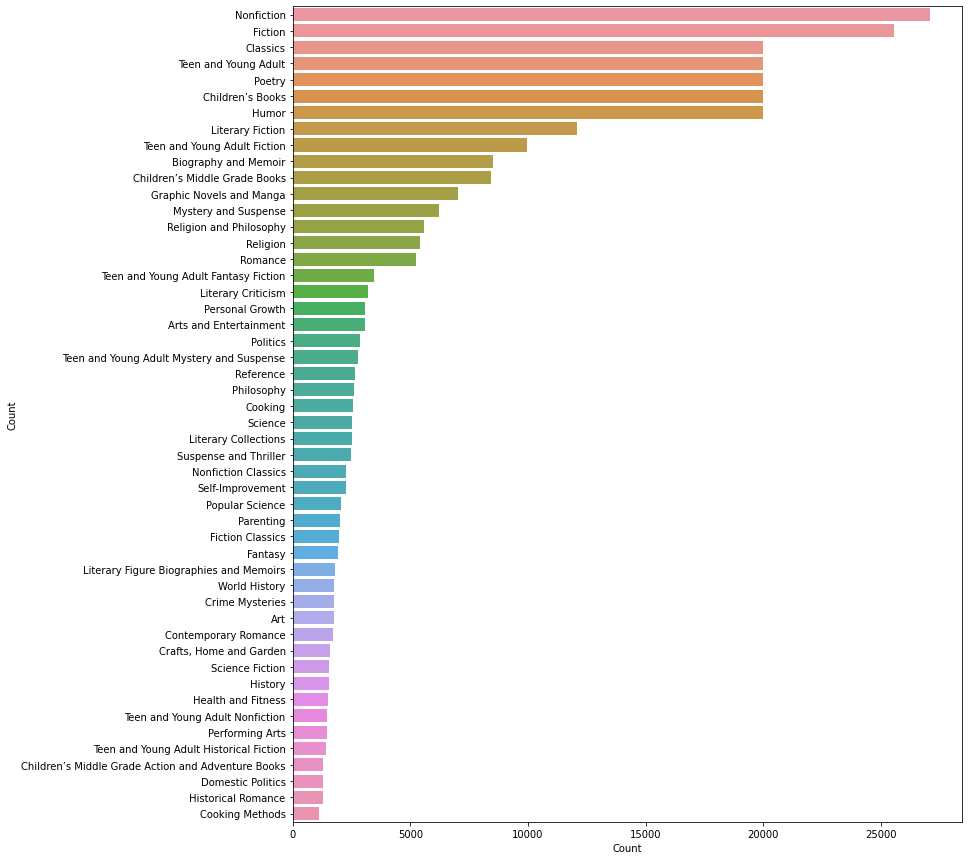

In [ ]:
draw_genre_plot(df)

In [ ]:
def clean_text(text):
    text = re.sub("\'", "", text) 
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    text = text.lower() 
    return text

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [ ]:
def freq_words(x, terms = 30): 
    word_count = {}
    for index,row in df.iterrows():
        text = row["Summary"]
        for w in nltk.word_tokenize(text):
            try:
                word_count[w] += 1
            except:
                word_count[w] = 1
                
    fdist = nltk.FreqDist(word_count) 
    words_df = pd.DataFrame({'word':list(word_count.keys()), 'count':list(word_count.values())}) 
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

In [ ]:
df['Summary'] = df['Summary'].apply(lambda x: clean_text(x))

The most frequent words out of all the words in the data:

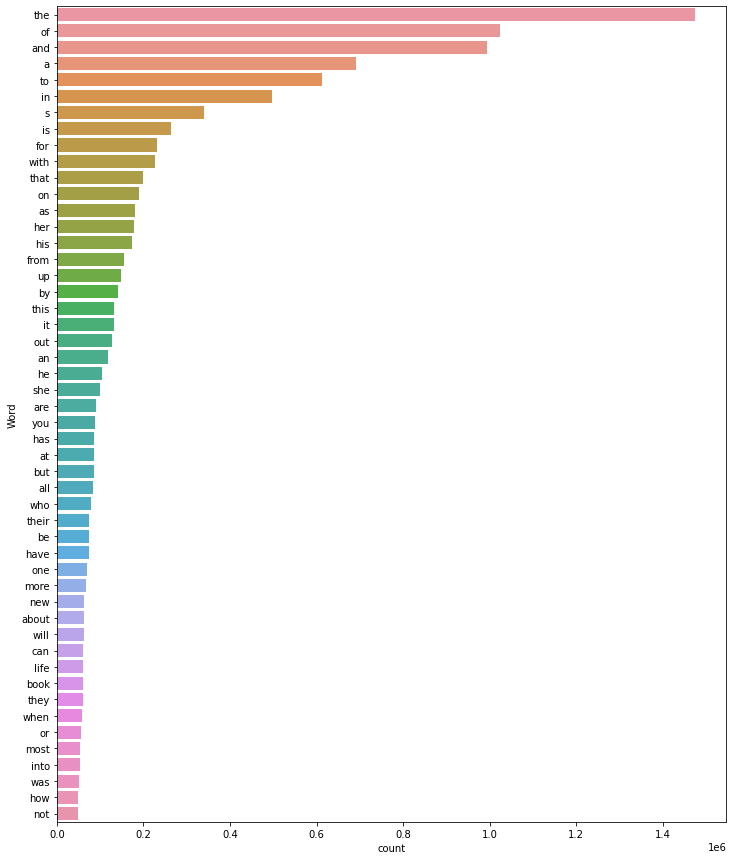

In [ ]:
freq_words(df['Summary'], 50)

Thus, we remove all stopwords for relevant data.

In [ ]:
df['Summary'] = df['Summary'].apply(lambda x: remove_stopwords(x))

The most frequent words after removing stopwords is as follows:

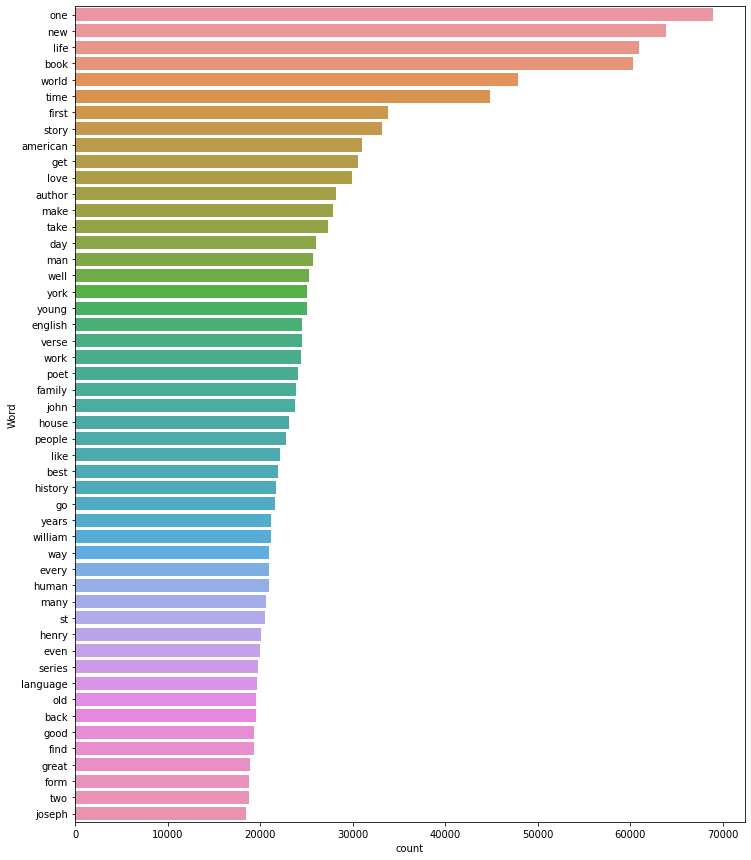

In [ ]:
freq_words(df['Summary'], 50)

In [ ]:
df.head()

,Name,Genres,Summary
0,"The New York Times Daily Crossword Puzzles: Thursday, Volume 1","[Games, Nonfiction]",monday crosswords easetuesday crosswords breezewednesday crosswords harder stillthursday crosswords take real skillfriday crosswords come far saturday crosswords star millions people new york times crossword puzzles essential day first cup coffee morning first time ever premier puzzles available...
1,Creatures of the Night (Second Edition),"[Graphic Novels and Manga, Fiction]",two literary comics modern masters present pair magical disturbing stories strange creatures quite seem price mysterious feline engages nightly conflict unseen vicious foe daughter owls recounts eerie tale beautiful orphan girl found clutching owl pellet would wrong would face bizarre unforeseen...
2,Cornelia and the Audacious Escapades of the Somerset Sisters,"[Children’s Middle Grade Books, Children’s Books]",eleven year old cornelia girl ii world famous pianists bequest feel fabulous instead feels plain lonely surrounds dictionaries books set apart outside world glamorous neighbour named virginia somerset moves next door servant patel pixilated french bulldog named mister kinyatta cornelia discovers...
3,The Alchemist's Daughter,"[Historical Fiction, Fiction]",english age reason woman cloistered since birth learns knowledge substitute experience raised father near isolation english countryside emilie selden trained brilliant natural philosopher alchemist spring father daughter embark upon daring alchemical experiment date attempting breathe life dead ...
4,Dangerous Boy,"[Teen and Young Adult Mystery and Suspense, Teen and Young Adult]",modern day retelling strange case dr jekyll mr hyde chilling twist harper never worried falling love something skeptical even exists everything changes logan moves town harper shock two tumble intense romance everything never thought wanted meets logan twin brother caleb expelled last school tru...


Storing the augmented data in a csv file.

In [ ]:
df.to_csv(r'.\augmented_data_50.csv', index = False)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
#from sklearn import preprocessing

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['Genres'])

# transform target variable
y = multilabel_binarizer.transform(df['Genres'])

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(df['Summary'], y, test_size=0.2, random_state=9)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [ ]:
import math
lr = LogisticRegression()

clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), max_df=0.8, max_features=10000)),
                ('tfidf', TfidfTransformer()),
                ('ovr', OneVsRestClassifier(lr))
               ])

In [ ]:
clf.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.8, max_features=10000,
                                 ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('ovr', OneVsRestClassifier(estimator=LogisticRegression()))])

In [ ]:
pickle.dump([clf, multilabel_binarizer], open('multi_label_50.sav', 'wb'))

In [ ]:
y_pred = clf.predict(xval)

In [ ]:
f1_score(yval, y_pred, average="micro")

0.7019471848913054

In [ ]:
y_pred_prob = clf.predict_proba(xval)
t = 0.2505
y_pred_new = (y_pred_prob >= t).astype(int)

In [ ]:
f1_score(yval, y_pred_new, average="micro")

0.7712376455523989

In [ ]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_pred_prob = clf.predict_proba([q])
    t = 0.2505
    q_pred_new = (q_pred_prob >= t).astype(int)

    return multilabel_binarizer.inverse_transform(q_pred_new)

In [ ]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Book: ", df['Name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",df['Genres'][k], "\n")

Book:  To the Edge of the World 
Predicted genre:  [('Teen and Young Adult',)]
Actual genre:  ['Teen and Young Adult Historical Fiction', 'Teen and Young Adult'] 

Book:  Thieves Get Rich, Saints Get Shot 
Predicted genre:  [('Fiction', 'Mystery and Suspense')]
Actual genre:  ['Suspense and Thriller', 'Mystery and Suspense', 'Fiction'] 

Book:  Peace, Love, and Mad Libs 
Predicted genre:  [('Humor',)]
Actual genre:  ['Children’s Middle Grade Books', 'Children’s Books'] 

Book:  American Heart Association Eat Less Salt 
Predicted genre:  [('Cooking', 'Diet and Nutrition', 'Nonfiction')]
Actual genre:  ['Diet and Nutrition', 'Cooking', 'Nonfiction'] 

Book:  Plenty 
Predicted genre:  [('Poetry',)]
Actual genre:  ['Poetry'] 



In [ ]:
# The Adventures of Tom Sawyer
infer_tags("The Adventures of Tom Sawyer is an 1876 novel by Mark Twain about a boy growing up along the Mississippi River. It is set in the 1840s in the town of St. Petersburg, which is based on Hannibal, Missouri, where Twain lived as a boy")

[('Children’s Books',
  'Children’s Middle Grade Books',
  'Classics',
  'Literary Fiction')]

In [ ]:
# Pride and Prejudice
infer_tags("Pride and Prejudice is set in rural England in the early 19th century, and it follows the Bennet family, which includes five very different sisters. Mrs. Bennet is anxious to see all her daughters married, especially as the modest family estate is to be inherited by William Collins when Mr. Bennet dies. At a ball, the wealthy and newly arrived Charles Bingley takes an immediate interest in the eldest Bennet daughter, the beautiful and shy Jane. The encounter between his friend Darcy and Elizabeth is less cordial. Although Austen shows them intrigued by each other, she reverses the convention of first impressions: pride of rank and fortune and prejudice against the social inferiority of Elizabeth’s family hold Darcy aloof, while Elizabeth is equally fired both by the pride of self-respect and by prejudice against Darcy’s snobbery. The pompous Collins subsequently arrives, hoping to marry one of the Bennet sisters. Elizabeth, however, refuses his offer of marriage, and he instead becomes engaged to her friend Charlotte Lucas. During this time, Elizabeth encounters the charming George Wickham, a military officer. There is a mutual attraction between the two, and he informs her that Darcy has denied him his inheritance. After Bingley abruptly departs for London, Elizabeth’s dislike of Darcy increases as she becomes convinced that he is discouraging Bingley’s relationship with Jane. Darcy, however, has grown increasingly fond of Elizabeth, admiring her intelligence and vitality. While visiting the now-married Charlotte, Elizabeth sees Darcy, who professes his love for her and proposes. A surprised Elizabeth refuses his offer, and, when Darcy demands an explanation, she accuses him of breaking up Jane and Bingley. Darcy subsequently writes Elizabeth a letter in which he explains that he separated the couple largely because he did not believe Jane returned Bingley’s affection. He also discloses that Wickham, after squandering his inheritance, tried to marry Darcy’s then 15-year-old sister in an attempt to gain possession of her fortune. With these revelations, Elizabeth begins to see Darcy in a new light. Shortly thereafter the youngest Bennet sister, Lydia, elopes with Wickham. The news is met with great alarm by Elizabeth, since the scandalous affair—which is unlikely to end in marriage—could ruin the reputation of the other Bennet sisters. When she tells Darcy, he persuades Wickham to marry Lydia, offering him money. Despite Darcy’s attempt to keep his intervention a secret, Elizabeth learns of his actions. At the encouragement of Darcy, Bingley subsequently returns, and he and Jane become engaged. Finally, Darcy proposes again to Elizabeth, who this time accepts.")

[('Fiction', 'Historical Romance', 'Literary Fiction', 'Romance')]

In [ ]:
# Harry Potter
infer_tags("Adaptation of the first of J.K. Rowling's popular children's novels about Harry Potter, a boy who learns on his eleventh birthday that he is the orphaned son of two powerful wizards and possesses unique magical powers of his own. He is summoned from his life as an unwanted child to become a student at Hogwarts, an English boarding school for wizards. There, he meets several friends who become his closest allies and help him discover the truth about his parents' mysterious deaths.")

[('Children’s Books',)]

In [ ]:
# The Theory of Everything
infer_tags("Based on a series of lectures given at Cambridge University, Professor Hawking's work introduced the history of ideas about the universe as well as today's most important scientific theories about time, space, and the cosmos in a clear, easy-to-understand way. The Theory of Everything presents the most complex theories, both past and present, of physics; yet it remains clear and accessible. It will enlighten readers and expose them to the rich history of scientific thought and the complexities of the universe in which we live.")

[('Nonfiction', 'Popular Science', 'Science')]

In [ ]:
# The Merchant of Venice
infer_tags("The Merchant of Venice is a 16th-century play written by William Shakespeare in which a merchant in
Venice named Antonio defaults on a large loan provided by a Jewish moneylender, Shylock. It is believed to have been written between 1596 and 1599")

[('Classics', 'Nonfiction Classics')]

In [ ]:
# Around The World in 80 days
infer_tags("Around the World in Eighty Days is an adventure novel by the French writer Jules Verne, first published in French in 1872. In the story, Phileas Fogg of London and his newly employed French valet Passepartout attempt to circumnavigate the world in 80 days on a wager GB£20,000 set by his friends at the Reform Club")

[('Classics', 'Fiction', 'Literary Fiction')]

In [ ]:
# Gitanjali
infer_tags("Gitanjali is a collection of poems by the Bengali poet Rabindranath Tagore. Tagore received the Nobel Prize for Literature, largely for the English translation, Song Offerings. It is part of the UNESCO Collection of Representative Works. Its central theme is devotion, and its motto is 'I am here to sing thee songs'.")

[('Classics', 'Poetry')]

In [ ]:
# The Wings of Fire
infer_tags("An Autobiography of APJ Abdul Kalam, former President of India. It was written by Dr. Abdul Kalam and Arun Tiwari. Dr. Kalam examines his early life, effort, hardship, fortitude, luck, and the chance that eventually led him to lead Indian space research, nuclear and missile programs")

[('Nonfiction',)]

In [ ]:
# My Experiments with Truth -by Mahatma Gandhi
infer_tags("The Story of My Experiments with Truth is the autobiography of Mahatma Gandhi, covering his life from early childhood through to 1921. It was written in weekly installments and published in his journal Navjivan from 1925 to 1929. Its English translation also appeared in installments in his other journal Young India")

[('Biography and Memoir', 'Classics')]

In [ ]:
# A Brief History of Time
infer_tags("A Brief History of Time: From the Big Bang to Black Holes is a book on theoretical cosmology by English physicist Stephen Hawking. It was first published in 1988. Hawking wrote the book for readers who had no prior knowledge of physics and people who are interested in learning something new about interesting subjects.")

[('Children’s Books', 'Nonfiction')]

In [ ]:
# Godaan - by Premchand
infer_tags("Godaan is a famous Hindi novel by Munshi Premchand. It was first published in 1936 and is considered one of the greatest Hindi novels of modern Indian literature. Themed around the socio-economic deprivation as well as the exploitation of the village poor, the novel was the last complete novel of Premchand")

[('Classics', 'Fiction', 'Literary Fiction')]

In [ ]:
# Sherlock Holmes
infer_tags("Sherlock Holmes is a fictional detective of the late 19th and early 20th centuries, who first appeared in publication in 1887. He was devised by British author and physician Sir Arthur Conan Doyle. A brilliant London-based detective, Holmes is famous for his prowess at using logic and astute observation to solve cases.")

[('Classics', 'Fiction', 'Literary Criticism', 'Mystery and Suspense')]